## Load and Normalize Data

In [366]:
import numpy as np
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [367]:
# Data file paths
train_raw_path, test_raw_path = r'..\data\train_raw.csv', r'..\data\test_raw.csv'
train_path, test_path = r'..\data\train.csv', r'..\data\test.csv'

# Open csv files
train_raw_data = np.loadtxt(train_raw_path, dtype='str', delimiter=',', unpack=True).T
test_raw_data = np.loadtxt(test_raw_path, dtype='str', delimiter=',', unpack=True).T

N_train, N_test = train_raw_data.shape[0] - 1, test_raw_data.shape[0] - 1
num_features = train_raw_data.shape[1] - 2

# Initialize arrays for train and test data
train_X, train_Y = np.zeros((N_train, train_raw_data.shape[1] - 2)), np.zeros((N_train, 1))
test_X = np.zeros((N_test, test_raw_data.shape[1] - 1))

In [368]:
formats = \
{
    0:  {'Female': 0, 'Male': 1},
    2:  {'No': 0, 'Yes': 1},
    3:  {'No': 0, 'Yes': 1},
    5:  {'No': 0, 'Yes': 1},
    6:  {'No phone service': 0, 'No': 1, 'Yes': 2},
    7:  {'No': 0, 'DSL': 1, 'Fiber optic': 2},
    8:  {'No internet service': 0, 'No': 1, 'Yes': 2},
    9:  {'No internet service': 0, 'No': 1, 'Yes': 2},
    10: {'No internet service': 0, 'No': 1, 'Yes': 2},
    11: {'No internet service': 0, 'No': 1, 'Yes': 2},
    12: {'No internet service': 0, 'No': 1, 'Yes': 2},
    13: {'No internet service': 0, 'No': 1, 'Yes': 2},
    14: {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    15: {'No': 0, 'Yes': 1},
    16: {'Mailed check': 0, 'Bank transfer (automatic)': 1, 'Electronic check': 2, 'Credit card (automatic)': 3},
}

for i in range(N_train):
    train_raw_x, train_raw_y = train_raw_data[i+1, 1:-1], train_raw_data[i+1, -1]
    
    train_x = np.zeros((num_features))
    for j in range(num_features):
        if j in formats.keys():
            train_x[j] = formats[j][train_raw_x[j]]
        else:
            if j == 18 and not train_raw_x[j]:              # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                train_x[j] = train_x[4] * train_x[17]  
            else:
                train_x[j] = eval(train_raw_x[j])
    
    train_y = 1 if train_raw_y == 'Yes' else 0
    
    
    train_X[i], train_Y[i] = train_x, train_y

for i in range(N_test):
    test_raw_x = test_raw_data[i+1, 1:]
    
    test_x = np.zeros((num_features))
    for j in range(num_features):
        if j in formats.keys():
            test_x[j] = formats[j][test_raw_x[j]]
        else:
            if j == 18 and not test_raw_x[j]:              # If 'Total Charges' missing, calculate from 'tenure' and 'Monthly Charges'
                test_x[j] = test_x[4] * test_x[17]  
            else:
                test_x[j] = eval(test_raw_x[j])
            
    test_X[i] = test_x

In [369]:
# for i in range(num_features):
#     min_ = np.min(train_X[:, i])
#     max_ = np.max(train_X[:, i])
    
#     train_X[:, i] = (train_X[:, i] - min_) / (max_ - min_)

# for i in range(num_features):
#     min_ = np.min(test_X[:, i])
#     max_ = np.max(test_X[:, i])
    
#     test_X[:, i] = (test_X[:, i] - min_) / (max_ - min_)

In [370]:
# for i in range(5):
#     print(train_X[i])
#     print(train_raw_data[i+1, 1:-1])

## Logistic/Ridge Regression

#### Find Best C/alpha (regularization) Values

In [371]:
def cross_validation_lr(X, Y, n_splits, C=1):
    kf = KFold(n_splits=n_splits)
    
    train_accs, val_accs = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = LogisticRegression(C=C)
        model.fit(X_train, Y_train)
        
        train_acc = model.score(X_train, Y_train)
        val_acc = model.score(X_val, Y_val)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    avg_train_acc, avg_val_acc = np.mean(train_accs), np.mean(val_accs)
    
    return avg_train_acc, avg_val_acc

n_splits = 5
lr_accs = {'train': [], 'val': []}
C_vals = [1] + list(range(0, 1001, 10))[1:]

for C in tqdm(C_vals):
    if C == 0:
        C = 1
    train_acc, val_acc = cross_validation_lr(train_X, train_Y, n_splits=n_splits, C=C)

    lr_accs['train'].append(train_acc)
    lr_accs['val'].append(val_acc)

100%|██████████| 101/101 [00:20<00:00,  4.95it/s]


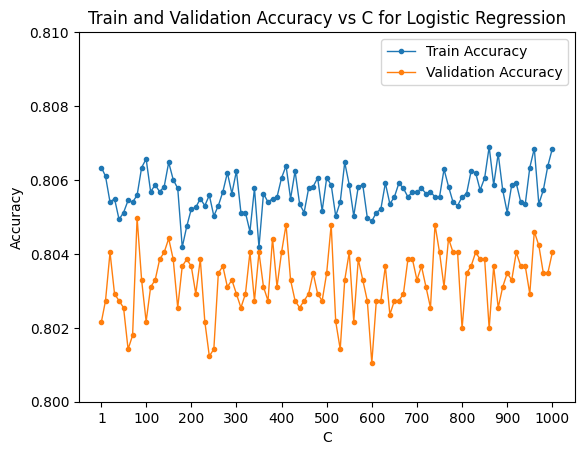

Val accuracy highest at C = 80 with val acc = 0.80498


In [372]:
plt.figure()

t = 1
plt.plot(C_vals[::t], lr_accs['train'][::t], marker='.', linewidth=1)
plt.plot(C_vals[::t], lr_accs['val'][::t], marker='.', linewidth=1)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs C for Logistic Regression')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
plt.ylim([.8, .81])
plt.xticks(C_vals[::10])

plt.show()

print(f"Val accuracy highest at C = {C_vals[np.argmax(lr_accs['val'])]} with val acc = {round(lr_accs['val'][np.argmax(lr_accs['val'])], 5)}")

In [373]:
def score_rr(model, X, Y, threshold=.5):
    Y_pred = model.predict(X)
    Y_pred_bin = np.where(Y_pred > threshold, 1, 0)
    
    return accuracy_score(Y, Y_pred_bin)

def cross_validation_rr(X, Y, n_splits, alpha=.01):
    kf = KFold(n_splits=n_splits)
    
    train_accs, val_accs = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = Ridge(alpha=alpha)
        model.fit(X_train, Y_train)
        
        train_acc = score_rr(model, X_train, Y_train)
        val_acc = score_rr(model, X_val, Y_val)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    avg_train_acc, avg_val_acc = np.mean(train_accs), np.mean(val_accs)
    
    return avg_train_acc, avg_val_acc

n_splits = 5
rr_accs = {'train': [], 'val': []}
alpha_vals = np.linspace(.01, 3, 300)

for alpha in tqdm(alpha_vals):
    train_acc, val_acc = cross_validation_rr(train_X, train_Y, n_splits=n_splits, alpha=alpha)

    rr_accs['train'].append(train_acc)
    rr_accs['val'].append(val_acc)

100%|██████████| 300/300 [00:02<00:00, 109.28it/s]


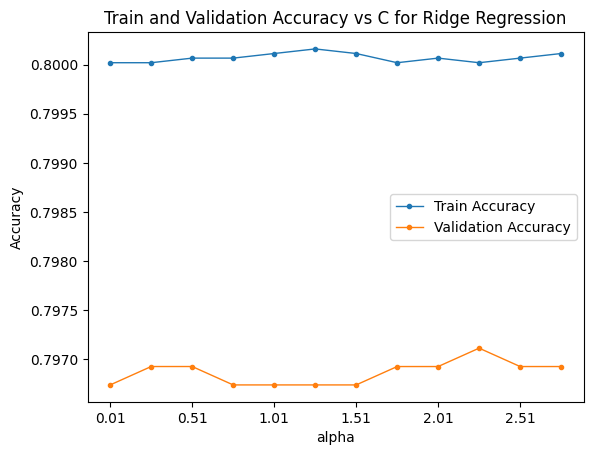

Val accuracy highest at alpha = 2.0599999999999996 with val acc = 0.79711


In [374]:
plt.figure()

t = 25
plt.plot(alpha_vals[::t], rr_accs['train'][::t], marker='.', linewidth=1)
plt.plot(alpha_vals[::t], rr_accs['val'][::t], marker='.', linewidth=1)
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs C for Ridge Regression')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
# plt.ylim([.8, .81])
plt.xticks(alpha_vals[::50])

plt.show()

print(f"Val accuracy highest at alpha = {alpha_vals[np.argmax(rr_accs['val'])]} with val acc = {round(rr_accs['val'][np.argmax(rr_accs['val'])], 5)}")

## Decision Trees

In [375]:
def classification_acc(y, real_y):
    N = len(y)
    
    num_mismatch = 0
    for i in range(N):
        if y[i] != real_y[i]:
            num_mismatch += 1
    
    return 1 - num_mismatch / N

def cross_validation_dt_clf(X, Y, n_splits, params=None):
    kf = KFold(n_splits=n_splits)
    
    train_accs, val_accs = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = DecisionTreeClassifier()
        if params:
            for param in params.keys():
                if param == 'min_samples_leaf':
                    model.set_params(min_samples_leaf=params['min_samples_leaf'])
                if param == 'max_depth':
                    model.set_params(max_depth=params['max_depth'])
                    
        model.fit(X_train, Y_train)
        
        train_acc = classification_acc(model.predict(X_train), Y_train)
        val_acc = classification_acc(model.predict(X_val), Y_val)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    avg_train_acc, avg_val_acc = np.mean(train_accs), np.mean(val_accs)
    
    return avg_train_acc, avg_val_acc

params = \
{
    'min_samples_leaf': 100,
    'max_depth': 4
}
train_acc, val_acc = cross_validation_dt_clf(train_X, train_Y, n_splits=5, params=params)

print(train_acc, val_acc)

0.7977258166473742 0.7954304663604544


In [376]:
def cross_validation_rf_clf(X, Y, n_estimators, n_splits, params=None):
    kf = KFold(n_splits=n_splits)
    
    train_accs, val_accs = [], []
    for train_index, val_index in kf.split(X):
        X_train, Y_train = X[train_index], Y[train_index]
        X_val, Y_val = X[val_index], Y[val_index]
        
        model = RandomForestClassifier(criterion='gini')
        if params:
            for param in params.keys():
                if param == 'min_samples_leaf':
                    model.set_params(min_samples_leaf=params['min_samples_leaf'])
                if param == 'max_depth':
                    model.set_params(max_depth=params['max_depth'])
                    
        model.fit(X_train, Y_train)
        
        train_acc = classification_acc(model.predict(X_train), Y_train)
        val_acc = classification_acc(model.predict(X_val), Y_val)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    avg_train_acc, avg_val_acc = np.mean(train_accs), np.mean(val_accs)
    
    return avg_train_acc, avg_val_acc

n_estimators = 1000
params = \
{
    'min_samples_leaf': 30,
    'max_depth': 5
}
train_acc, val_acc = cross_validation_rf_clf(train_X, train_Y, n_estimators=n_estimators, n_splits=5)

print(train_acc, val_acc)

0.9978008302615844 0.793186428563921


In [393]:
def generate_submission(file_path, model, customer_IDs, test_Y):
    test_Y = model.predict(test_X)
    
    file = open(file_path, 'w')
    file.write('ID, TARGET\n')
    for i, id in enumerate(customer_IDs):
        line = f"{id}, {test_Y[i]}"
        if i != len(customer_IDs) - 1:
            line += '\n'
            
        file.write(line)
    file.close()

# model = LogisticRegression(C=80)
model = DecisionTreeClassifier(criterion='gini')
params = \
{
    'min_samples_leaf': 100,
    'max_depth': 4
}
if params:
    for param in params.keys():
        if param == 'min_samples_leaf':
            model.set_params(min_samples_leaf=params['min_samples_leaf'])
        if param == 'max_depth':
            model.set_params(max_depth=params['max_depth'])

model.fit(train_X, train_Y)
test_Y = model.predict(test_X)
generate_submission('..\submissions\\rf_1.csv', model, test_raw_data.T[0, 1:], model.predict(test_X))